### Things To Consider

#### Other Regression Techniques 
Try out more algorithms and compare their performances with what we have done. Read up more on the pros and cons of using the different models and when are they more applicable.

* Bayesian Linear Regression
* Least Angle Regression
* Huber Regression

#### Other Scaling Methods
Understand the use cases of different scalers and compare the results.

* Min-Max Scaler
* RobustScaler
* Normalize

#### Importing Libraries

In [162]:
# Standard Libraries
from scipy import stats
import pandas as pd
import numpy as np
import pickle
import time

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # higher resolution plots

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, BayesianRidge, LassoLars

# Misc
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore')

# Random State #
SEED = 8888

#### Loading Our Data

In [2]:
with open('cleaned_dataset.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,RoofStyle,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,FireplaceQu,GarageFinish,GarageCars,GarageQual,PavedDrive,YrSold,LogSalePrice,LogLotFrontage,LogLotArea,LogFirstFlrSF,LogGroundArea,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,MSSubClass_SC70,MSSubClass_SC75,MSSubClass_SC80,...,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrArea_VnrArea_Small,MasVnrArea_VnrArea_Medium,MasVnrArea_VnrArea_Large,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtFinSF1_BsmtSF_Small,BsmtFinSF1_BsmtSF_Medium,BsmtFinSF1_BsmtSF_Large,BsmtFinSF1_BsmtSF_ExtraLarge,2ndFlrSF_SecondFlr_Small,2ndFlrSF_SecondFlr_Medium,2ndFlrSF_SecondFlr_Large,2ndFlrSF_SecondFlr_ExtraLarge,GarageType_BuiltIn,GarageType_Detchd,GarageType_NoGarage,GarageType_Other,WoodDeckSF_WoodDeckSF_Small,WoodDeckSF_WoodDeckSF_Medium,WoodDeckSF_WoodDeckSF_Large,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFence,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial
0,0,0,7,5,2003,0,4,3,4,3,1,6,1,150,856,5,1,1,1,0,2,1,3,1,4,8,1,0,2,2,3,1.0,2008,12.247699,4.189655,9.042040,6.753438,7.444249,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,0,0,6,8,1976,0,3,3,4,3,4,5,1,284,1262,5,1,1,0,1,2,0,3,1,3,6,1,3,2,2,3,1.0,2007,12.109016,4.394449,9.169623,7.141245,7.140453,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
2,1,0,7,5,2001,0,4,3,4,3,2,6,1,434,920,5,1,1,1,0,2,1,3,1,4,6,1,3,2,2,3,1.0,2008,12.317171,4.234107,9.328212,6.825460,7.487734,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
3,1,0,7,5,1915,0,3,3,3,4,1,5,1,540,756,4,1,1,1,0,1,0,3,1,4,7,1,4,1,3,3,1.0,2006,11.849405,4.110874,9.164401,6.869014,7.448334,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,8,5,2000,0,4,3,4,3,3,6,1,490,1145,5,1,1,1,0,2,1,4,1,4,9,1,3,2,3,3,1.0,2008,12.429220,4.442651,9.565284,7.044033,7.695303,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


#### Splitting our Dataset

In [4]:
X = df.drop('LogSalePrice', axis=1)
y = df.LogSalePrice

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X ,y, test_size=0.2, random_state=SEED)

#### Defining Functions

In [6]:
def adj_r_square(X, model_r2):
    '''
    Calculates the adjusted R-Square of the model.
    
    :params:
        X (array): Array of independent variables' values.
        model_r2 (float): R-Square of the model fitted on the same array x as the independent variables.
        
    :returns:
        adj_r2 (float): Adjusted R-Square of the model fitted. 
        
    '''
    n = X[:].size # Number of observations #
    k = X[0].size # Number of parameters # 
    adj_r2 = 1 - (1-model_r2) * ((n-1)/(n-k-1))
    
    return adj_r2

In [7]:
def kfold_linear_model(X, y, cv=5):
    '''
    Function that performs cross validation and returns the RMSE of the training and validation datasets.
    
    :returns:
        training_rmse : List of training RMSE scores.
        validation_rmse : List of validation RMSE scores.
        
    '''
    # Lists to store our results
    training_rmse = []
    validation_rmse = []
    
    training_r2 = []
    validation_r2 = []
    
    training_adj_r2 = []
    validation_adj_r2 = []
    
    # Converting data into ndarrays
    X = np.array(X)
    y = np.array(y)
    
    model = LinearRegression(fit_intercept=True, n_jobs=-1)
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)
    
    for train_index, valid_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_valid, y_valid = X[valid_index], y[valid_index]
        
        model.fit(X_train, y_train)
        
        # Saving RMSE
        train_resid = y_train - model.predict(X_train)
        train_rmse = np.sqrt(np.mean(train_resid**2))
        training_rmse.append(train_rmse)
        
        valid_resid = y_valid - model.predict(X_valid)
        valid_rmse = np.sqrt(np.mean(valid_resid**2))
        validation_rmse.append(valid_rmse)
        
        # Saving R Squared
        train_r_squared = model.score(X_train, y_train)
        training_r2.append(train_r_squared)
        
        valid_r_squared = model.score(X_valid, y_valid)
        validation_r2.append(valid_r_squared)
        
        # Saving Adjusted R Squared
        training_adj_r2.append(adj_r_square(X_train, train_r_squared))
        validation_adj_r2.append(adj_r_square(X_valid, valid_r_squared))
    
    RMSE = {'Training' : training_rmse,
            'Validation' : validation_rmse}
    
    R_Squared = {'Training' : training_r2,
                 'Validation' : validation_r2}
    
    Adj_R_Squared = {'Training' : training_adj_r2,
                     'Validation' : validation_adj_r2}
    
    return RMSE, R_Squared, Adj_R_Squared

In [30]:
def kfold_lasso_model(X, y, optimal_alpha, cv=5):
    '''
    Function that performs cross validation and returns the RMSE of the training and validation datasets.
    
    :returns:
        training_rmse : List of training RMSE scores.
        validation_rmse : List of validation RMSE scores.
        
    '''
    # Lists to store our results
    training_rmse = []
    validation_rmse = []
    
    training_r2 = []
    validation_r2 = []
    
    training_adj_r2 = []
    validation_adj_r2 = []
    
    # Converting data into ndarrays
    X = np.array(X)
    y = np.array(y)
    
    model = Pipeline(steps=[('Standardise', StandardScaler()),
                            ('Lasso', Lasso(alpha=optimal_alpha, random_state=SEED))
                           ])
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)
    
    for train_index, valid_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_valid, y_valid = X[valid_index], y[valid_index]
        
        model.fit(X_train, y_train)
        
        # Saving RMSE
        train_resid = y_train - model.predict(X_train)
        train_rmse = np.sqrt(np.mean(train_resid**2))
        training_rmse.append(train_rmse)
        
        valid_resid = y_valid - model.predict(X_valid)
        valid_rmse = np.sqrt(np.mean(valid_resid**2))
        validation_rmse.append(valid_rmse)
        
        # Saving R Squared
        train_r_squared = model.score(X_train, y_train)
        training_r2.append(train_r_squared)
        
        valid_r_squared = model.score(X_valid, y_valid)
        validation_r2.append(valid_r_squared)
        
        # Saving Adjusted R Squared
        training_adj_r2.append(adj_r_square(X_train, train_r_squared))
        validation_adj_r2.append(adj_r_square(X_valid, valid_r_squared))
    
    RMSE = {'Training' : training_rmse,
            'Validation' : validation_rmse}
    
    R_Squared = {'Training' : training_r2,
                 'Validation' : validation_r2}
    
    Adj_R_Squared = {'Training' : training_adj_r2,
                     'Validation' : validation_adj_r2}
    
    return RMSE, R_Squared, Adj_R_Squared

In [286]:
def kfold_ridge_model(X, y, optimal_alpha, cv=5):
    '''
    Function that performs cross validation and returns the RMSE of the training and validation datasets.
    
    :returns:
        training_rmse : List of training RMSE scores.
        validation_rmse : List of validation RMSE scores.
        
    '''
    # Lists to store our results
    training_rmse = []
    validation_rmse = []
    
    training_r2 = []
    validation_r2 = []
    
    training_adj_r2 = []
    validation_adj_r2 = []
    
    # Converting data into ndarrays
    X = np.array(X)
    y = np.array(y)
    
    model = Pipeline(steps=[('Standardise', StandardScaler()),
                            ('Ridge', Ridge(alpha=optimal_alpha))
                           ])
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)
    
    for train_index, valid_index in kf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_valid, y_valid = X[valid_index], y[valid_index]
        
        model.fit(X_train, y_train)
        
        # Saving RMSE
        train_resid = y_train - model.predict(X_train)
        train_rmse = np.sqrt(np.mean(train_resid**2))
        training_rmse.append(train_rmse)
        
        valid_resid = y_valid - model.predict(X_valid)
        valid_rmse = np.sqrt(np.mean(valid_resid**2))
        validation_rmse.append(valid_rmse)
        
        # Saving R Squared
        train_r_squared = model.score(X_train, y_train)
        training_r2.append(train_r_squared)
        
        valid_r_squared = model.score(X_valid, y_valid)
        validation_r2.append(valid_r_squared)
        
        # Saving Adjusted R Squared
        training_adj_r2.append(adj_r_square(X_train, train_r_squared))
        validation_adj_r2.append(adj_r_square(X_valid, valid_r_squared))
    
    RMSE = {'Training' : training_rmse,
            'Validation' : validation_rmse}
    
    R_Squared = {'Training' : training_r2,
                 'Validation' : validation_r2}
    
    Adj_R_Squared = {'Training' : training_adj_r2,
                     'Validation' : validation_adj_r2}
    
    return RMSE, R_Squared, Adj_R_Squared

In [38]:
def model_results_summary(RMSE, R_Squared, Adj_R_Squared, model_type):
    print(' '*13, '{} Results Summary'.format(model_type))
    print('=' * 61)
    print('\t'*2,'Mean RMSE', '\t', 'Mean R^2', '\t', 'Mean Adj R^2')
    
    print('Training',
          '\t', '{:.4f}'.format(np.mean(RMSE['Training'])),
          '\t', '{:.4f}'.format(np.mean(R_Squared['Training'])),
          '\t', '{:.4f}'.format(np.mean(Adj_R_Squared['Training'])))
    
    print('Validation',
          '\t','{:.4f}'.format(np.mean(RMSE['Validation'])),
          '\t', '{:.4f}'.format(np.mean(R_Squared['Validation'])),
          '\t', '{:.4f}'.format(np.mean(Adj_R_Squared['Validation'])))

In [9]:
def lasso_alpha_plots(alphas, X_train, y_train, X_valid, y_valid, fig_size=(6,6), return_series=False):
    '''
    Function that plots the RMSEs of the training and validation datasets across different alpha values for Lasso Regression.
    
    :params:
        alphas : Vector of different alpha values to try. 
        
    '''
    rmse_training = []
    rmse_validation = []
    
    for alpha in alphas:
        lasso_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                                     ('Lasso', Lasso(alpha=alpha, random_state=SEED))
                                    ])
        model = lasso_pipe.fit(X_train, y_train)
        
        resid_train = y_train - model.predict(X_train)
        rmse_train = np.sqrt(np.mean(resid_train**2))
        rmse_training.append(rmse_train)
        
        resid_valid = y_valid - model.predict(X_valid)
        rmse_valid = np.sqrt(np.mean(resid_valid**2))
        rmse_validation.append(rmse_valid)
        
    rmse_training = pd.Series(rmse_training, index=alphas)
    rmse_validation = pd.Series(rmse_validation, index=alphas)

    # Plotting the RMSE Scores 
    plt.figure(figsize=fig_size)
    plt.title('Training and Validation RMSE over different Alphas')
    
    training_ax = rmse_training.plot(color='blue', grid=True, label='Training RMSE')
    validation_ax = rmse_validation.plot(color='red', grid=True, label='Validation RMSE')
    
    plt.legend(loc='center right')
    plt.show()
    
    if return_series:
        return rmse_training, rmse_validation

In [293]:
def ridge_alpha_plots(alphas, X_train, y_train, X_valid, y_valid, fig_size=(6,6), return_series=False):
    '''
    Function that plots the RMSEs of the training and validation datasets across different alpha values for Ridge Regression.
    
    :params:
        alphas : Vector of different alpha values to try. 
        
    '''
    rmse_training = []
    rmse_validation = []
    
    for alpha in alphas:
        ridge_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                                     ('Ridge', Ridge(alpha=alpha, random_state=SEED))
                                    ])
        model = ridge_pipe.fit(X_train, y_train)
        
        resid_train = y_train - model.predict(X_train)
        rmse_train = np.sqrt(np.mean(resid_train**2))
        rmse_training.append(rmse_train)
        
        resid_valid = y_valid - model.predict(X_valid)
        rmse_valid = np.sqrt(np.mean(resid_valid**2))
        rmse_validation.append(rmse_valid)
        
    rmse_training = pd.Series(rmse_training, index=alphas)
    rmse_validation = pd.Series(rmse_validation, index=alphas)

    # Plotting the RMSE Scores 
    plt.figure(figsize=fig_size)
    plt.title('Training and Validation RMSE over different Alphas')
    
    training_ax = rmse_training.plot(color='blue', grid=True, label='Training RMSE')
    validation_ax = rmse_validation.plot(color='red', grid=True, label='Validation RMSE')
    
    plt.legend(loc='center right')
    plt.show()
    
    if return_series:
        return rmse_training, rmse_validation

### Base Model : Linear Regression

In [11]:
linreg_rmse, linreg_score, linreg_adj_score = kfold_linear_model(X_train, y_train)

In [39]:
model_results_summary(linreg_rmse, linreg_score, linreg_adj_score, model_type='Linear Regression')

              Linear Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1019 	 0.9359 	 0.9358
Validation 	 0.1450 	 0.8685 	 0.8679


In [13]:
linreg_rmse

{'Training': [0.1008946096268675,
  0.09797858399427398,
  0.10276900824988268,
  0.10366291991688917,
  0.1044260954104371],
 'Validation': [0.14436562326348357,
  0.18311836604946116,
  0.12987548753316855,
  0.13050226259988285,
  0.13715430534578923]}

In [14]:
linreg_score

{'Training': [0.9375904961833754,
  0.9398631364096985,
  0.9357432071047574,
  0.9332682550582917,
  0.9329683648614795],
 'Validation': [0.8684550370658175,
  0.8047564835492986,
  0.8899693305489523,
  0.8977084693298999,
  0.8814661944480229]}

In [15]:
linreg_adj_score

{'Training': [0.9375231715777804,
  0.9397982634276151,
  0.9356738897256098,
  0.9331962678106112,
  0.9328960541055512],
 'Validation': [0.8678855635008919,
  0.8039112514791248,
  0.8894929948825323,
  0.8972656373024847,
  0.8809530477086402]}

### Lassso Regression Model

#### Investigating how RMSE changes as Alpha changes

In [16]:
alpha_vector = 10**np.linspace(-3,2,100)

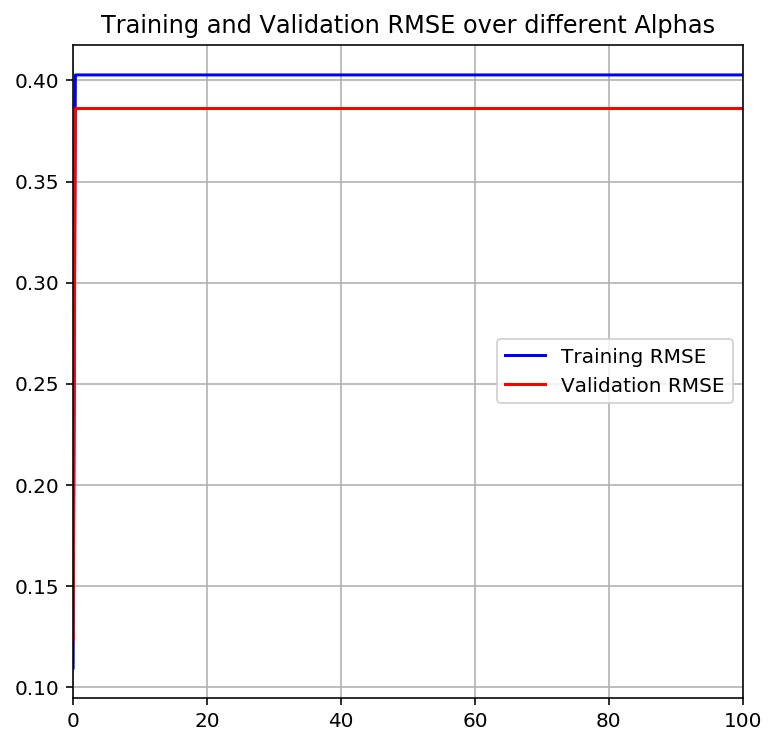

In [17]:
lasso_alpha_plots(alpha_vector, X_train, y_train, X_valid, y_valid)

From the diagram above, it appears that our optimal alpha is very small. Therefore, changing the range of alphas to loop over.

In [18]:
alpha_vector = np.linspace(0,1,101)

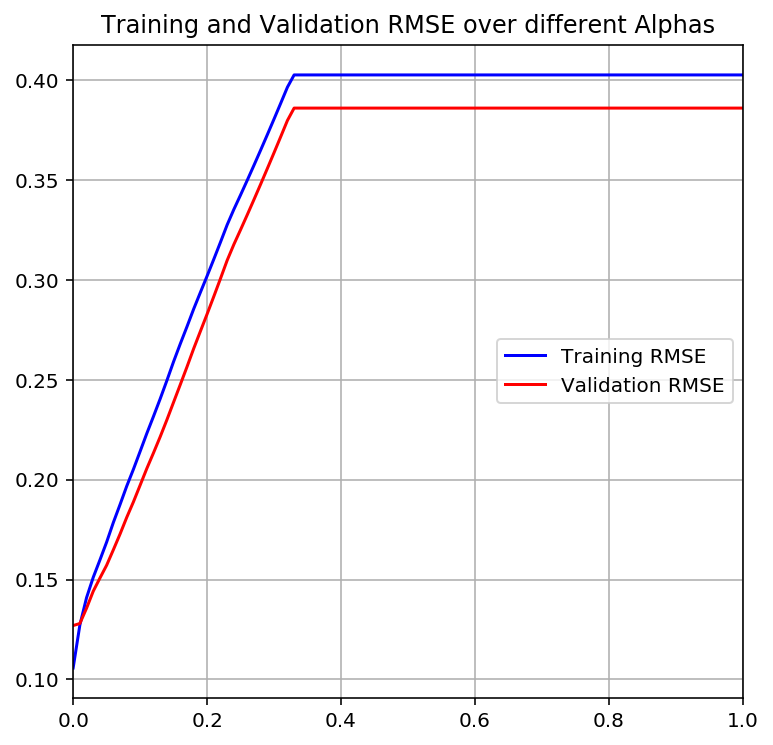

In [19]:
lasso_alpha_plots(alpha_vector, X_train, y_train, X_valid, y_valid)

While the training RMSE appears to increase monotonically before plateauing, there appears to be a minimum point for the validation RMSE. Let's adjust our alpha vector and take a closer look. 

In [20]:
alpha_vector = np.linspace(0,0.1,101)

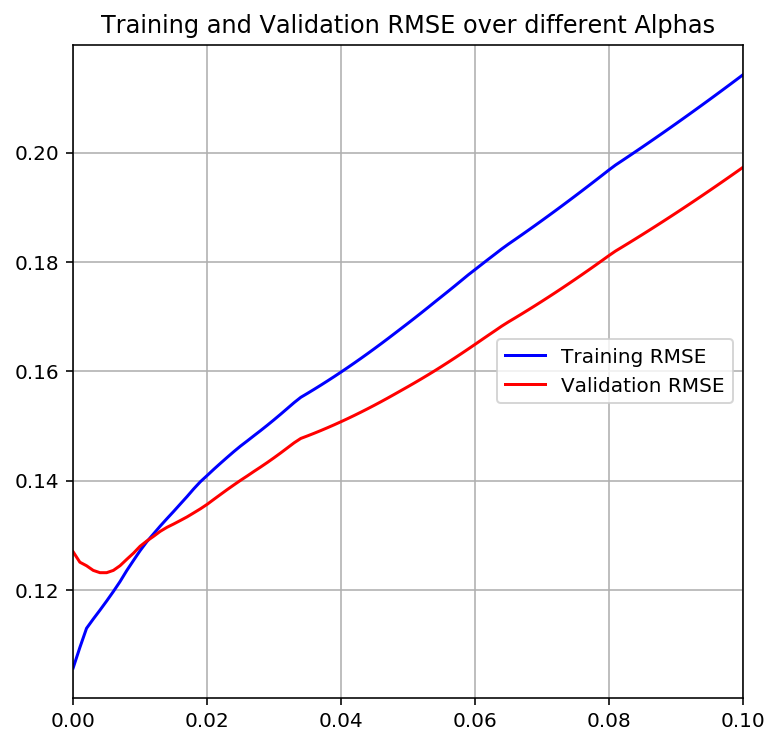

In [21]:
lasso_rmse_train, lasso_rmse_valid = lasso_alpha_plots(alpha_vector, X_train, y_train, X_valid, y_valid, return_series=True)

In [22]:
# Taking a look at the alpha that corresponds to the lowest RMSE
lasso_rmse_valid.nsmallest(n=1).index

Float64Index([0.005], dtype='float64')

Now that we have a rough idea what our optimal alpha should be, we can use a GridSearch to find the optimal alpha as well as other parameters. We cannot use the alpha taken from the above analysis as there was no cross validation done during the process.

#### Grid Search Cross Validation for Optimal Alpha

In [23]:
gs_alpha_vector = np.linspace(0.001, 0.01, 10)

In [24]:
# Lasso Model Pipeline
lasso_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                             ('Lasso', Lasso(random_state=SEED)
                             )])

# Parameters to tune
parameters_lasso = {'Lasso__alpha' : gs_alpha_vector,
                    'Lasso__fit_intercept' : [True, False]}

In [25]:
# Defining and fitting the Grid Search estimator
gscv_lasso = GridSearchCV(lasso_pipe, parameters_lasso, n_jobs=-1,
                          scoring='neg_mean_squared_error', verbose=False, cv=5)

gscv_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('Lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=8888,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
  

In [26]:
gscv_lasso.best_params_

{'Lasso__alpha': 0.003, 'Lasso__fit_intercept': True}

In [28]:
# Saving the optimal alpha for lasso model
alpha_lasso = gscv_lasso.best_params_['Lasso__alpha']

#### Lasso Model Results Using Optimal Alpha

In [31]:
lasso_rmse, lasso_score, lasso_adj_score = kfold_lasso_model(X_train, y_train, optimal_alpha=alpha_lasso)

In [41]:
lasso_rmse

{'Training': [0.11194227701988396,
  0.10617099503497701,
  0.11277096403544512,
  0.11429392040897578,
  0.11627403692403727],
 'Validation': [0.1274386158774161,
  0.17374222984823903,
  0.12575163973568615,
  0.12216436996214897,
  0.11330473051343487]}

In [42]:
lasso_score

{'Training': [0.9231749105851258,
  0.9293860945394575,
  0.922627024090493,
  0.9188792671515501,
  0.9168949842235427],
 'Validation': [0.8974941303704337,
  0.8242385632511232,
  0.8968458542009843,
  0.9103618853066362,
  0.9191054204035694]}

In [43]:
lasso_adj_score

{'Training': [0.923092035084948,
  0.9293099193891372,
  0.922543557554657,
  0.9187917577016971,
  0.9168053342172463],
 'Validation': [0.8970503704445371,
  0.8234776713877692,
  0.8963992878115558,
  0.9099738314002834,
  0.9187552182856138]}

In [40]:
model_results_summary(lasso_rmse, lasso_score, lasso_adj_score, model_type='Lasso Regression')

              Lasso Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1123 	 0.9222 	 0.9221
Validation 	 0.1325 	 0.8896 	 0.8891


### Ridge Regression Model

#### Investigating how RMSE changes as Alpha changes

In [201]:
alpha_vector = 10**np.linspace(-3,3,100)

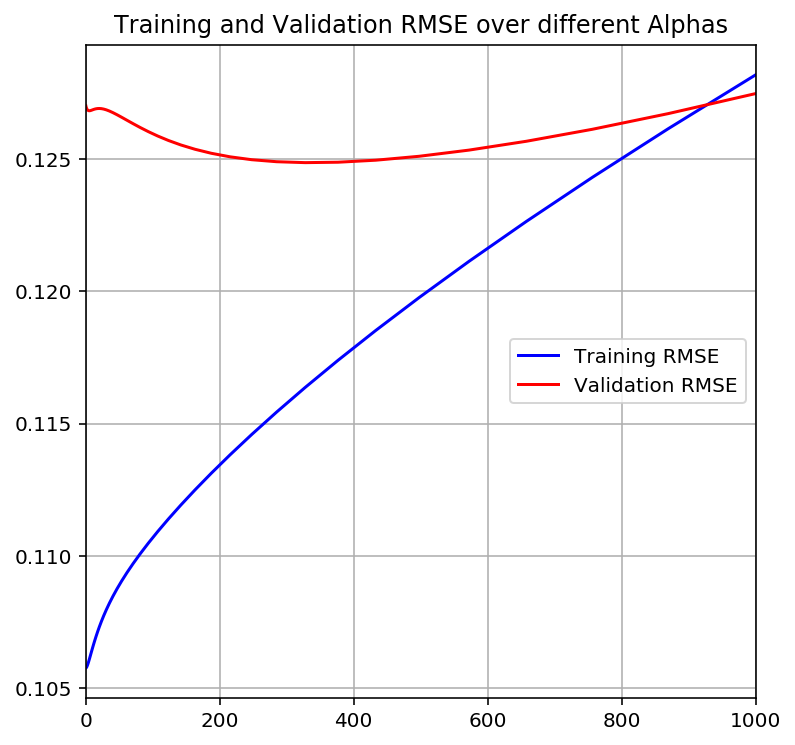

In [203]:
ridge_rmse_train, ridge_rmse_valid = ridge_alpha_plots(alpha_vector, X_train, y_train, X_valid, y_valid, return_series=True)

In [204]:
ridge_rmse_train.nsmallest(n=1).index

Float64Index([0.001], dtype='float64')

In [205]:
ridge_rmse_valid.nsmallest(n=1).index

Float64Index([327.4549162877732], dtype='float64')

Minimum point for validation RMSE is alpha = 327. Lets take a closer look at the plot over a smaller range. 

In [251]:
alpha_vector = np.arange(200,500, step=10)

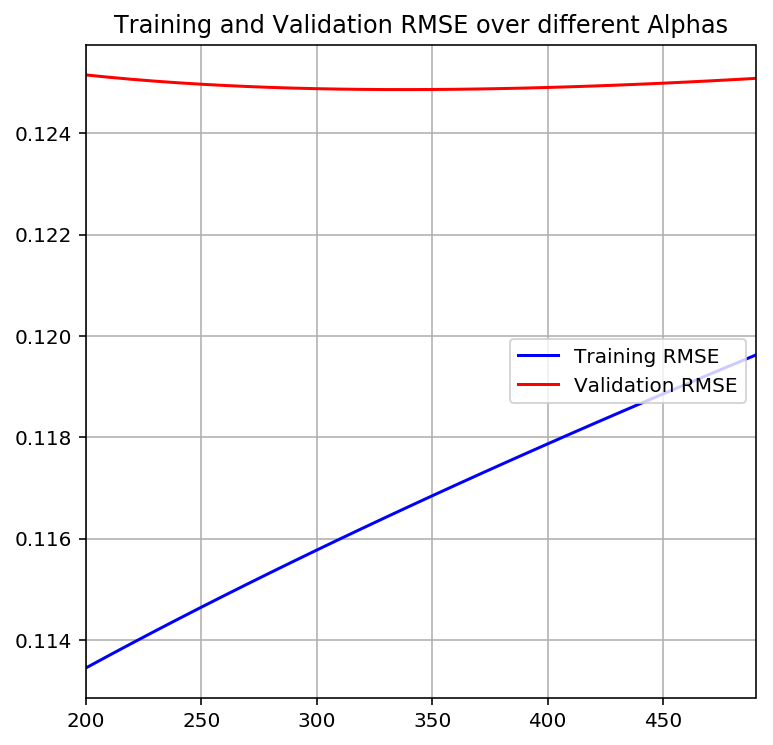

In [252]:
ridge_rmse_train, ridge_rmse_valid = ridge_alpha_plots(alpha_vector, X_train, y_train, X_valid, y_valid, return_series=True)

In [254]:
ridge_rmse_train.nsmallest(n=1).index

Int64Index([200], dtype='int64')

In [255]:
ridge_rmse_valid.nsmallest(n=1).index

Int64Index([340], dtype='int64')

It is hard to tell if an Alpha of 340 is truly the best alpha as the the RMSE is very similar over the entire range and we have not done cross validation. Therefore, it is best to iterate our GridSearch over a larger range of Alphas. 

As our dataset is small, this is not too much of a concern.

#### Grid Search Cross Validation for Optimal Alpha

In [256]:
alpha_vector = np.arange(200, 501, step=1)

In [257]:
# Ridge pipeline for Grid Search
ridge_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                             ('Ridge', Ridge(random_state=SEED))
                            ])

# Ridge paramters to tune 
parameters_ridge = {'Ridge__alpha' : alpha_vector,
                    'Ridge__fit_intercept' : [True, False]}

In [258]:
# Defining and fitting the Grid Search estimator
gscv_ridge = GridSearchCV(ridge_pipe, parameters_ridge, n_jobs=-1,
                          scoring='neg_mean_squared_error', verbose=False, cv=5)

gscv_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('Ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=8888, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'Ridge__alph...
       447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,
       460, 461, 462, 463, 464, 465, 46

In [259]:
gscv_ridge.best_params_

{'Ridge__alpha': 223, 'Ridge__fit_intercept': True}

In [260]:
ridge_alpha = gscv_ridge.best_params_['Ridge__alpha']

#### Ridge Model Using Optimal Alpha

In [261]:
ridge_rmse, ridge_score, ridge_adj_score = kfold_ridge_model(X_train, y_train, ridge_alpha)

In [262]:
ridge_rmse

{'Training': [0.1122364346598775,
  0.10640939265414108,
  0.11347208662618345,
  0.11437237933516312,
  0.11653876151987758],
 'Validation': [0.13500151686734452,
  0.16578336536869137,
  0.12732900249980725,
  0.12960432748045014,
  0.11884988450225906]}

In [263]:
ridge_score

{'Training': [0.9227706240263697,
  0.9290686239011117,
  0.9216619427391196,
  0.9187678556237026,
  0.9165161380724884],
 'Validation': [0.8849666045596417,
  0.8399724652564223,
  0.8942418008001524,
  0.899111282737224,
  0.9109936757648973]}

In [264]:
ridge_adj_score

{'Training': [0.9226873123997775,
  0.9289921062775427,
  0.9215774351163117,
  0.918680225988033,
  0.9164260793837616],
 'Validation': [0.8844686115059686,
  0.8392796872992588,
  0.893783961158291,
  0.8986745236534941,
  0.9106083569535001]}

In [265]:
model_results_summary(ridge_rmse, ridge_score, ridge_adj_score, model_type='Ridge Regression')

              Ridge Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1126 	 0.9218 	 0.9217
Validation 	 0.1353 	 0.8859 	 0.8854


### Comparing Results

#### Linear Model

In [266]:
model_results_summary(linreg_rmse, linreg_score, linreg_adj_score, model_type='Linear Regression')

              Linear Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1019 	 0.9359 	 0.9358
Validation 	 0.1450 	 0.8685 	 0.8679


#### Lasso Model

In [267]:
model_results_summary(lasso_rmse, lasso_score, lasso_adj_score, model_type='Lasso Regression')

              Lasso Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1123 	 0.9222 	 0.9221
Validation 	 0.1325 	 0.8896 	 0.8891


#### Ridge Model

In [268]:
model_results_summary(ridge_rmse, ridge_score, ridge_adj_score, model_type='Ridge Regression')

              Ridge Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1126 	 0.9218 	 0.9217
Validation 	 0.1353 	 0.8859 	 0.8854


From the results above, we can see that regularisation greatly improves the results, with Lasso and Ridge Regressions having lower RMSE scores but higher R Squred as compared to the Linear Model. 

Comparing Lasso and Ridge, the Lasso Regression Model performs slightly better than the Ridge.

### Dimensionality Reduction
As the Lasso model performed the best, it may suggest that there are alot of redundant variables in our dataset. Therefore, we will do some feature selection using the Lasso model.

We will remove the variables that have zero coefficients in the Lasso model and run our models again on the new dataset.

In [170]:
# Saving the best model from our grid search
lasso_model = gscv_lasso.best_estimator_.named_steps['Lasso']

In [174]:
# Saving the coefficents of the models as a series with the index as their variable names
lasso_coeff = pd.Series(lasso_model.coef_, index=X_train.columns)

In [179]:
# Creating a list of variables that have coefficients of zero
zero_coeff_vars = lasso_coeff.loc[lasso_coeff == 0].index.to_list()

In [180]:
df_lean = df.drop(zero_coeff_vars, axis=1)

In [359]:
# Saving New Dataset
with open('feature_engineered_dataset.pickle', 'wb') as f:
    pickle.dump(df_lean, f)

In [185]:
print('Feature Selection Using Lasso Regression')
print('='*40)
print('Original Dataframe had {} features.'.format(df.shape[1]))
print('New Dataframe has {} features.'.format(df_lean.shape[1]))
print('Lasso Regression has removed {} redundant features.'.format(df.shape[1] - df_lean.shape[1]))

Feature Selection Using Lasso Regression
Original Dataframe had 167 features.
New Dataframe has 82 features.
Lasso Regression has removed 85 redundant features.


#### Splitting Our New Dataset

In [187]:
X2 = df_lean.drop('LogSalePrice', axis=1)

In [188]:
X2_train, X2_valid, y_train, y_valid = train_test_split(X2 ,y, test_size=0.2, random_state=SEED)

### Linear Regression Model Post Feature Selection

In [344]:
linreg_rmse2, linreg_score2, linreg_adj_score2 = kfold_linear_model(X2_train, y_train)

In [345]:
model_results_summary(linreg_rmse2, linreg_score2, linreg_adj_score2, model_type='Linear Regression')

              Linear Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1104 	 0.9248 	 0.9247
Validation 	 0.1255 	 0.9018 	 0.9014


### Lasso Regression Model Post Feature Selection

In [321]:
alpha_vector = 10**np.linspace(-3,2,100)

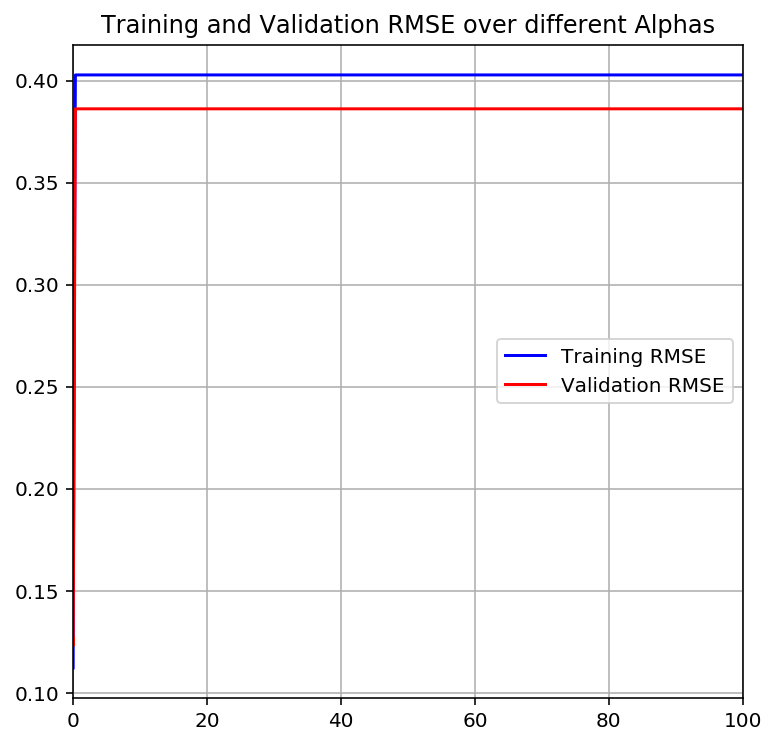

In [322]:
lasso_rmse_train, lasso_rmse_valid = lasso_alpha_plots(alpha_vector, X2_train, y_train, X2_valid, y_valid, return_series=True)

In [324]:
alpha_vector = np.linspace(0,0.1,101)

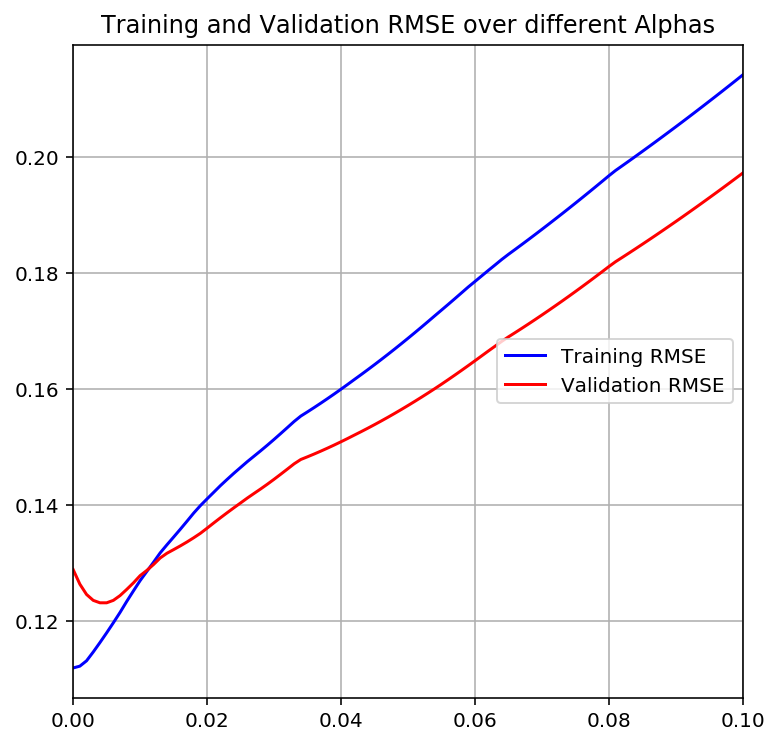

In [325]:
lasso_rmse_train, lasso_rmse_valid = lasso_alpha_plots(alpha_vector, X2_train, y_train, X2_valid, y_valid, return_series=True)

In [326]:
gs_alpha_vector = np.linspace(0.001, 0.01, 10)

In [328]:
# Lasso Model Pipeline
lasso_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                             ('Lasso', Lasso(random_state=SEED)
                             )])

# Parameters to tune
parameters_lasso = {'Lasso__alpha' : gs_alpha_vector,
                    'Lasso__fit_intercept' : [True, False]}

In [331]:
# Defining and fitting the Grid Search estimator
gscv_lasso = GridSearchCV(lasso_pipe, parameters_lasso, n_jobs=-1,
                          scoring='neg_mean_squared_error', verbose=False, cv=5)

gscv_lasso.fit(X2_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('Lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=8888,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
  

In [332]:
gscv_lasso.best_params_

{'Lasso__alpha': 0.001, 'Lasso__fit_intercept': True}

In [333]:
alpha_lasso = gscv_lasso.best_params_['Lasso__alpha']

In [334]:
lasso_rmse2, lasso_score2, lasso_adj_score2 = kfold_lasso_model(X2_train, y_train, optimal_alpha=alpha_lasso)

In [336]:
model_results_summary(lasso_rmse2, lasso_score2, lasso_adj_score2, model_type='Lasso Regression')

              Lasso Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1107 	 0.9244 	 0.9243
Validation 	 0.1253 	 0.9020 	 0.9016


### Ridge Regression Model Post Feature Selection

In [294]:
alpha_vector = 10**np.linspace(-3,3,100)

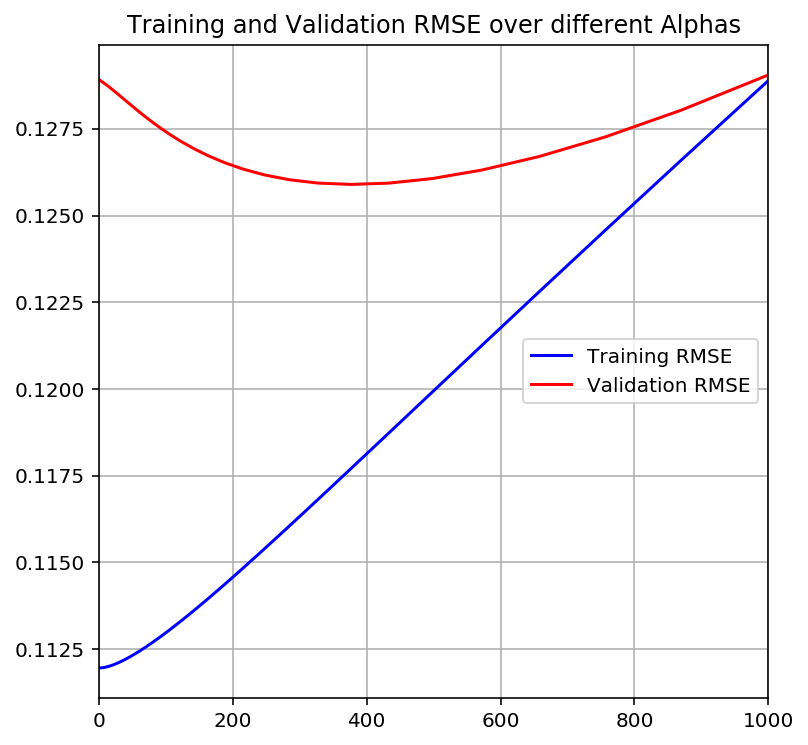

In [295]:
ridge_rmse_train, ridge_rmse_valid = ridge_alpha_plots(alpha_vector, X2_train, y_train, X2_valid, y_valid, return_series=True)

In [227]:
ridge_rmse_valid.nsmallest(n=1).index

Float64Index([376.49358067924715], dtype='float64')

Our optimal alpha for Ridge Regression seems to have changed. Let's iterate across a smaller range of alphas.

In [296]:
alpha_vector = np.arange(250, 500, step=10)

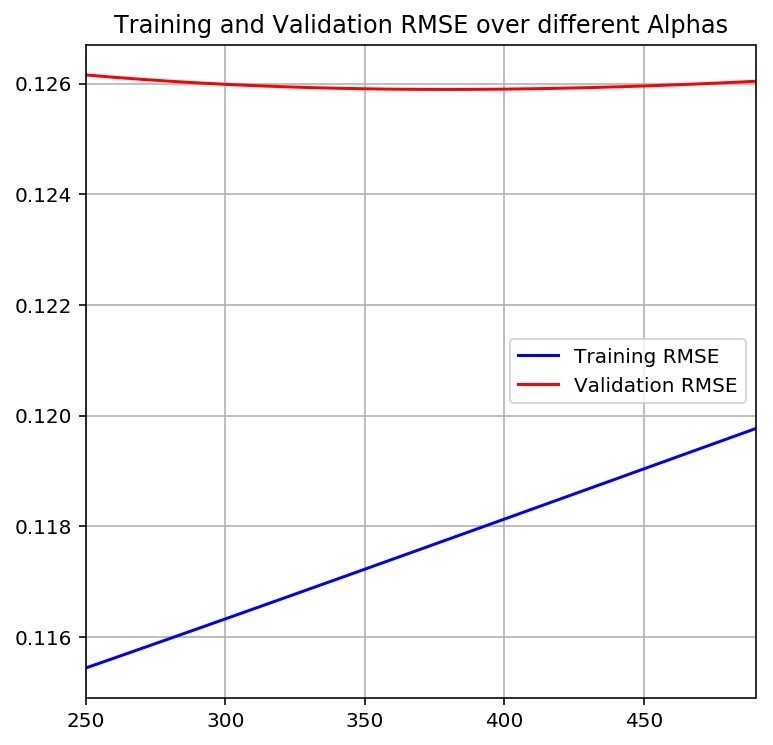

In [297]:
ridge_rmse_train, ridge_rmse_valid = ridge_alpha_plots(alpha_vector, X2_train, y_train, X2_valid, y_valid, return_series=True)

In [298]:
ridge_rmse_valid.nsmallest(n=1).index

Int64Index([380], dtype='int64')

Once again, we have a rough idea what our optimal alpha should be and we can now use a grid search to determine the optimal alpha with cross validation.

#### Grid Search Cross Validation for Optimal Alpha

In [304]:
alpha_vector = np.arange(300,401,step=5)

In [305]:
# Ridge pipeline for Grid Search
ridge_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                             ('Ridge', Ridge(random_state=SEED))
                            ])

# Ridge paramters to tune 
parameters_ridge = {'Ridge__alpha' : alpha_vector,
                    'Ridge__fit_intercept' : [True, False]}

In [306]:
# Defining and fitting the Grid Search estimator
gscv_ridge = GridSearchCV(ridge_pipe, parameters_ridge, n_jobs=-1,
                          scoring='neg_mean_squared_error', verbose=False, cv=5)

gscv_ridge.fit(X2_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('Ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=8888, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'Ridge__alpha': array([300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360,
       365, 370, 375, 380, 385, 390, 39

In [307]:
gscv_ridge.best_params_

{'Ridge__alpha': 300, 'Ridge__fit_intercept': True}

As our optimal alpha is the lower end of the range of alphas iterated through, there is a chance that the optimal alpha is actually smaller. Therefore, we will run the Grid Search over a new range of alphas.

In [308]:
alpha_vector = np.arange(0,301,step=5)

In [309]:
# Ridge pipeline for Grid Search
ridge_pipe = Pipeline(steps=[('Standardise', StandardScaler()),
                             ('Ridge', Ridge(random_state=SEED))
                            ])

# Ridge paramters to tune 
parameters_ridge = {'Ridge__alpha' : alpha_vector,
                    'Ridge__fit_intercept' : [True, False]}

In [310]:
# Defining and fitting the Grid Search estimator
gscv_ridge = GridSearchCV(ridge_pipe, parameters_ridge, n_jobs=-1,
                          scoring='neg_mean_squared_error', verbose=False, cv=5)

gscv_ridge.fit(X2_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('Ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=8888, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'Ridge__alph...,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       1

In [311]:
gscv_ridge.best_params_

{'Ridge__alpha': 85, 'Ridge__fit_intercept': True}

In [313]:
ridge_alpha = gscv_ridge.best_params_['Ridge__alpha']

#### Fitting Ridge Regression with Optimal Alpha

In [349]:
ridge_rmse2, ridge_score2, ridge_adj_score2 = kfold_ridge_model(X2_train, y_train, ridge_alpha)

In [350]:
model_results_summary(ridge_rmse2, ridge_score2, ridge_adj_score2, model_type='Ridge Regression')

              Ridge Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1116 	 0.9232 	 0.9231
Validation 	 0.1245 	 0.9034 	 0.9030


### Comparing Results Post Feature Selection

### Previous Lasso Model

In [353]:
model_results_summary(lasso_rmse, lasso_score, lasso_adj_score, model_type='Ridge Regression')

              Ridge Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1123 	 0.9222 	 0.9221
Validation 	 0.1325 	 0.8896 	 0.8891


### Linear Regression Model

In [354]:
model_results_summary(linreg_rmse2, linreg_score2, linreg_adj_score2, model_type='Linear Regression')

              Linear Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1104 	 0.9248 	 0.9247
Validation 	 0.1255 	 0.9018 	 0.9014


### Lasso Regression Model

In [355]:
model_results_summary(lasso_rmse2, lasso_score2, lasso_adj_score2, model_type='Ridge Regression')

              Ridge Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1107 	 0.9244 	 0.9243
Validation 	 0.1253 	 0.9020 	 0.9016


### Ridge Regression Model

In [356]:
model_results_summary(ridge_rmse2, ridge_score2, ridge_adj_score2, model_type='Ridge Regression')

              Ridge Regression Results Summary
		 Mean RMSE 	 Mean R^2 	 Mean Adj R^2
Training 	 0.1116 	 0.9232 	 0.9231
Validation 	 0.1245 	 0.9034 	 0.9030


After doing feature selection, the model performaces of all three algorithms have improved, with lower Validation RMSE and higher R Squared values. 

The performance of all three models are relatively close, but the Ridge Regression had marginally better performance post feature selection.